In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [4]:
provider = q.IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [5]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

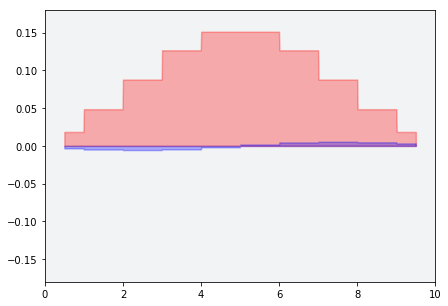

In [5]:
cmd_def.get('x', qubits=[0]).instructions[0][1].command.draw(scaling=0.18)

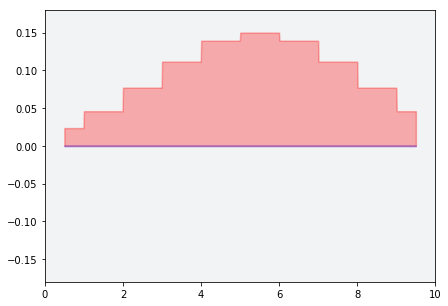

In [6]:
# Approximate X as a gaussian pulse:
DURATION = 10
AMP = 0.15
SIGMA = 2.6
q.pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=SIGMA).draw(scaling=0.18)

------------

In [7]:
MEASUREMENT_START_TIMESTEP = 20

In [9]:
# just measure
schedule = q.pulse.Schedule()
schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
print(job.job_id())

5d9635ecb87c6200191f21d9


In [10]:
# X, then measure
schedule = q.pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])
schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
print(job.job_id())

5d9635f2de3ef200180cf73a


In [11]:
# X, then pulse at 1-2 frequency, then measure
schedule = q.pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])

freq = config.dt * 0.304  # anharmonicity is 304 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = q.pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * q.pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = q.pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP / np.sqrt(2), sigma=SIGMA).samples
schedule |= q.pulse.SamplePulse(gaussian_samples * wave_samples)(system.qubits[0].drive) << schedule.duration

schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
print(job.job_id())

5d9635f5b99007001972c5c3


In [12]:
job_ids = ['5d9635ecb87c6200191f21d9', '5d9635f2de3ef200180cf73a', '5d9635f5b99007001972c5c3']
jobs = [backend.retrieve_job(job_id) for job_id in job_ids]

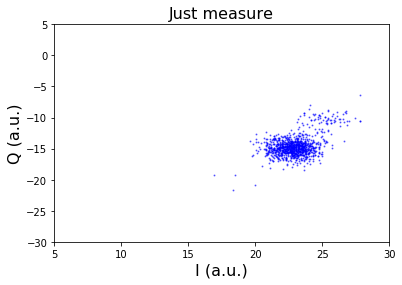

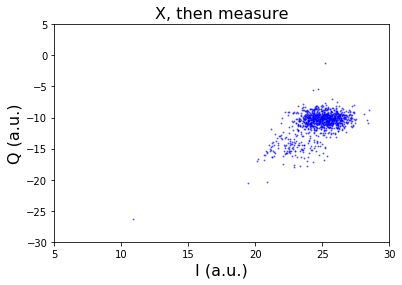

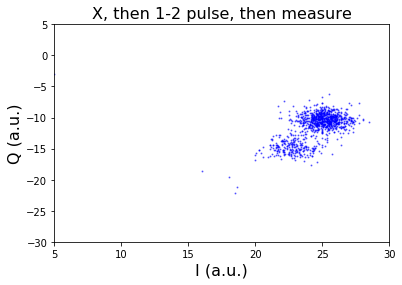

In [17]:
for (job, title) in zip(jobs, ['Just measure', 'X, then measure', 'X, then 1-2 pulse, then measure']):
    result = job.result()
    memory_shots = result.get_memory()
    qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

    plt.title(title, fontsize=16)
    plt.xlabel('I (a.u.)', fontsize=16); plt.xlim(5, 30)
    plt.ylabel('Q (a.u.)', fontsize=16); plt.ylim(-30, 5)
    plt.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
                s=1, cmap='viridis',c='blue',alpha=0.5)
    plt.show()